# Predict energy generation from weather data with Machine Learning

From data collected in Germany (2016), predict Wind/Solar Generation using a simple linear regression algorithm

In [4]:
# import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Renewable Energy Data
Focus on Germany, 2016. Datasets (https://open-power-system-data.org/):
* Time series (load, wind and solar, prices in hourly resolution). 
* Weather (wind speed, radiation, temperature etc).

### 1.1. Production data
Read csv file containing German renewable energy Production data and assess onshore vs offshore wind power.

In [5]:
production = pd.read_csv("time_series_60min_singleindex_filtered_2016.csv", parse_dates=[0], index_col=0)

In [6]:
production.head(2)

,cet_cest_timestamp,DE_load_actual_entsoe_power_statistics,DE_load_actual_entsoe_transparency,DE_load_forecast_entsoe_transparency,DE_price_day_ahead,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity,DE_wind_generation_actual,DE_wind_profile,DE_wind_offshore_capacity,DE_wind_offshore_generation_actual,DE_wind_offshore_profile,DE_wind_onshore_capacity,DE_wind_onshore_generation_actual,DE_wind_onshore_profile
utc_timestamp,,,,,,,,,,,,,,,,,
2015-12-31 23:00:00+00:00,2016-01-01T00:00:00+0100,44682.92643,40952,40129.0,23.86,39159,0,0.0,43663,8638,0.1978,3297,2272,0.6892,40366,6365,0.1577
2016-01-01 00:00:00+00:00,2016-01-01T01:00:00+0100,42768.20408,39396,38163.0,22.39,39159,0,0.0,43663,8579,0.1965,3297,2286,0.6933,40366,6294,0.1559


In [7]:
production.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2015-12-31 23:00:00+00:00 to 2016-12-31 22:00:00+00:00
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   cet_cest_timestamp                      8784 non-null   object 
 1   DE_load_actual_entsoe_power_statistics  8784 non-null   float64
 2   DE_load_actual_entsoe_transparency      8784 non-null   int64  
 3   DE_load_forecast_entsoe_transparency    8736 non-null   float64
 4   DE_price_day_ahead                      8783 non-null   float64
 5   DE_solar_capacity                       8784 non-null   int64  
 6   DE_solar_generation_actual              8784 non-null   int64  
 7   DE_solar_profile                        8784 non-null   float64
 8   DE_wind_capacity                        8784 non-null   int64  
 9   DE_wind_generation_actual               8784 non-null   int64  
 10  DE_wind_prof

### Exploratory Data Analysis
Plot time series for actual wind generation on and offshore, for comparison.

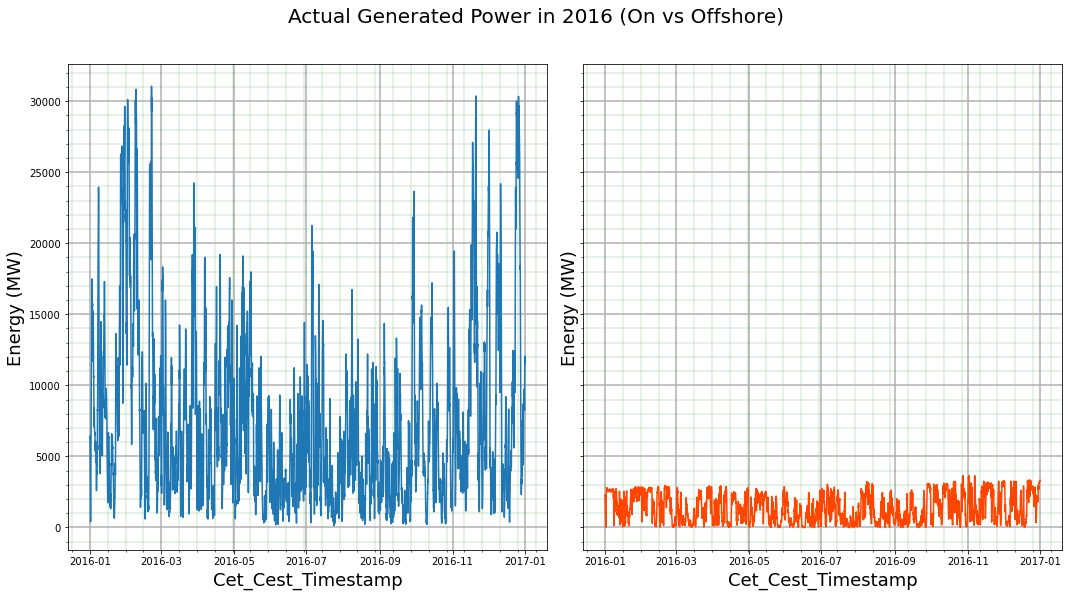

In [8]:
# create plot
P1 = production['DE_wind_onshore_generation_actual']
P2 = production['DE_wind_offshore_generation_actual']
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8))
fig.suptitle('Actual Generated Power in 2016 (On vs Offshore)', y=1.03, fontsize=20)
ax1.plot(P1)
ax2.plot(P2, c='OrangeRed')
ax1.set_xlabel('Cet_Cest_Timestamp', fontsize = 18)
ax2.set_xlabel('Cet_Cest_Timestamp', fontsize = 18)
ax1.set_ylabel('Energy (MW)', fontsize = 18)
ax2.set_ylabel('Energy (MW)', fontsize = 18)
ax1.minorticks_on()
ax2.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='1.5')
ax2.grid(which='major', linestyle='-', linewidth='1.5')
ax1.grid(which='minor', linestyle='-', linewidth='0.2', color='g')
ax2.grid(which='minor', linestyle='-', linewidth='0.2', color='g')
plt.tight_layout()

As seen from the above two plots, offshore wind is more consistent but has nowhere near the onshore generation. Germany does not have a huge coastline like say the UK, and hence its wind farm developments are spread moreso on land.

Note that the following line of code sets up a specific DataFrame to merge with a Weather Dataframe later in this Notebook.

In [9]:
production_wind = production.loc[production.index.year == 2016, ['DE_wind_generation_actual']] 

In [10]:
production_wind.head(5)

,DE_wind_generation_actual
utc_timestamp,
2016-01-01 00:00:00+00:00,8579
2016-01-01 01:00:00+00:00,8542
2016-01-01 02:00:00+00:00,8443
2016-01-01 03:00:00+00:00,8295
2016-01-01 04:00:00+00:00,7319


In [11]:
production_wind.tail(5)

,DE_wind_generation_actual
utc_timestamp,
2016-12-31 18:00:00+00:00,15196
2016-12-31 19:00:00+00:00,15303
2016-12-31 20:00:00+00:00,15354
2016-12-31 21:00:00+00:00,14848
2016-12-31 22:00:00+00:00,15056


### 1.2. Weather data

Read weather data for Germany 2016. The data in focus is wind; namely at 10 meters above displacement height.

In [12]:
weather = pd.read_csv("weather_data_DE_filtered_2016.csv", parse_dates=[0], index_col=0)

In [13]:
weather.head(2)

,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,DE11_windspeed_10m,DE11_temperature,DE11_radiation_direct_horizontal,DE11_radiation_diffuse_horizontal,DE12_windspeed_10m,DE12_temperature,...,DEE0_radiation_direct_horizontal,DEE0_radiation_diffuse_horizontal,DEF0_windspeed_10m,DEF0_temperature,DEF0_radiation_direct_horizontal,DEF0_radiation_diffuse_horizontal,DEG0_windspeed_10m,DEG0_temperature,DEG0_radiation_direct_horizontal,DEG0_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,3.384917,2.064,0.0,0.0,1.73,2.05,0.0,0.0,2.45,2.03,...,0.0,0.0,4.66,3.16,0.0,0.0,3.22,0.21,0.0,0.0
2016-01-01 01:00:00+00:00,3.363631,1.965,0.0,0.0,1.73,1.84,0.0,0.0,2.50,1.90,...,0.0,0.0,4.39,2.95,0.0,0.0,3.22,0.23,0.0,0.0


In [14]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2016-01-01 00:00:00+00:00 to 2016-12-31 23:00:00+00:00
Columns: 156 entries, DE_windspeed_10m to DEG0_radiation_diffuse_horizontal
dtypes: float64(156)
memory usage: 10.5 MB


### Exploratory Data Analysis

Plot time series for wind speed at 10m above displacement height for comparing different regions within Germany, at random.

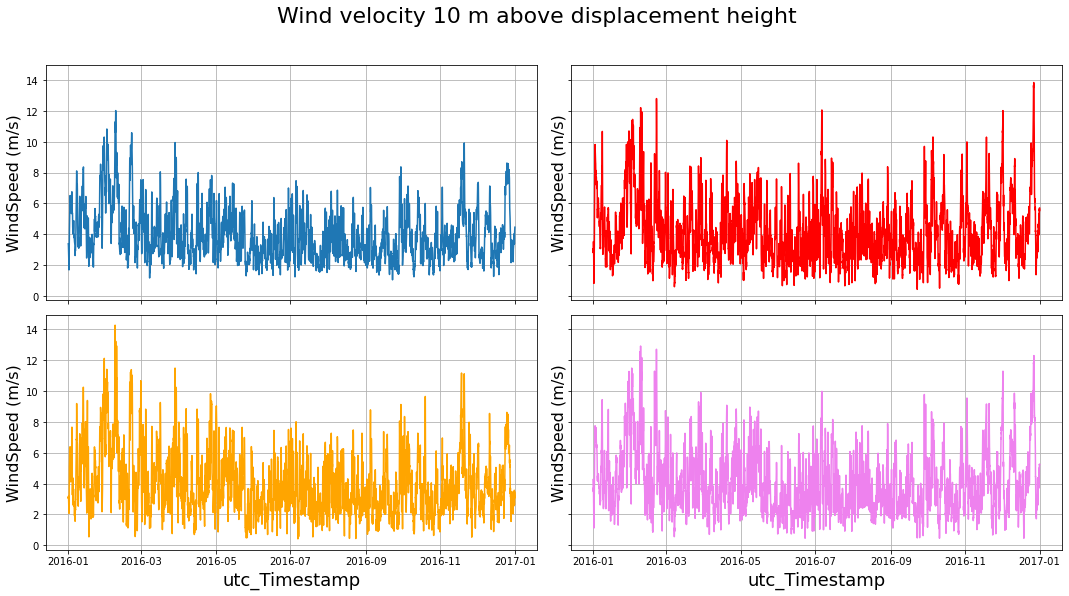

In [15]:
# create plot
P1 = weather['DE_windspeed_10m']  
P2 = weather['DE40_windspeed_10m'] 
P3 = weather['DE72_windspeed_10m'] 
P4 = weather['DEE0_windspeed_10m'] 

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (15,8))
fig.suptitle('Wind velocity 10 m above displacement height', y = 1.03, fontsize = 22)
ax1.plot(P1)
ax2.plot(P2, c = 'Red')
ax3.plot(P3, c = 'Orange')
ax4.plot(P4, c = 'Violet')
ax3.set_xlabel('utc_Timestamp', fontsize = 18)
ax4.set_xlabel('utc_Timestamp', fontsize = 18)
ax1.set_ylabel('WindSpeed (m/s)', fontsize = 16)
ax2.set_ylabel('WindSpeed (m/s)', fontsize = 16)
ax3.set_ylabel('WindSpeed (m/s)', fontsize = 16)
ax4.set_ylabel('WindSpeed (m/s)', fontsize = 16)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.tight_layout()

The above plots show wind velocity has similar peaks at differnet times of year, irrespective of specific location. Germany is not a large country, say like Australia, and hence it stands to reason the variation (trend) is not excessive. Obviously, certain regions show stronger wind speeds overall, and hence could potentially be target locations for future wind farm developments. 

Note also, the dataset is provided with 'chuncks' of German geographical territory, each determined by its latitute ('lat') and longitute ('lon'). Each chunck corresponds to the MERRA-2 grid resolution (used to obtain the data) which is 0.5º x 0.625º.

Thus for any given hour we have data for 256 'chuncks' of Germany. Dividing total number of entries by number of 'chuncks' returns expected number of hours of a leap year.

In [16]:
2248704/256

8784.0

For example, data for time 2016-01-01 00:00:00 is calaculated as follows:

In [17]:
weather.loc[weather.index == '2016-01-01 00:00:00', :]

,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,DE11_windspeed_10m,DE11_temperature,DE11_radiation_direct_horizontal,DE11_radiation_diffuse_horizontal,DE12_windspeed_10m,DE12_temperature,...,DEE0_radiation_direct_horizontal,DEE0_radiation_diffuse_horizontal,DEF0_windspeed_10m,DEF0_temperature,DEF0_radiation_direct_horizontal,DEF0_radiation_diffuse_horizontal,DEG0_windspeed_10m,DEG0_temperature,DEG0_radiation_direct_horizontal,DEG0_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,3.384917,2.064,0.0,0.0,1.73,2.05,0.0,0.0,2.45,2.03,...,0.0,0.0,4.66,3.16,0.0,0.0,3.22,0.21,0.0,0.0


And now averaging over all 'chunks':

In [18]:
weather_by_day = weather.groupby(weather.index).mean()

In [19]:
weather_by_day.head(2)

,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,DE11_windspeed_10m,DE11_temperature,DE11_radiation_direct_horizontal,DE11_radiation_diffuse_horizontal,DE12_windspeed_10m,DE12_temperature,...,DEE0_radiation_direct_horizontal,DEE0_radiation_diffuse_horizontal,DEF0_windspeed_10m,DEF0_temperature,DEF0_radiation_direct_horizontal,DEF0_radiation_diffuse_horizontal,DEG0_windspeed_10m,DEG0_temperature,DEG0_radiation_direct_horizontal,DEG0_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,3.384917,2.064,0.0,0.0,1.73,2.05,0.0,0.0,2.45,2.03,...,0.0,0.0,4.66,3.16,0.0,0.0,3.22,0.21,0.0,0.0
2016-01-01 01:00:00+00:00,3.363631,1.965,0.0,0.0,1.73,1.84,0.0,0.0,2.50,1.90,...,0.0,0.0,4.39,2.95,0.0,0.0,3.22,0.23,0.0,0.0


## 2. Merge DataFrames

As seen in above plots, from both datasets, there seems to be correlations. Now, merging the two DataFrames.

In [36]:
# merge production_wind and weather_by_day DataFrames
combined = pd.merge(production_wind, weather_by_day, how='left', left_index=True, right_index=True)
combined = combined.fillna(method='ffill')

In [37]:
combined.head()

,DE_wind_generation_actual,DE_windspeed_10m,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,DE11_windspeed_10m,DE11_temperature,DE11_radiation_direct_horizontal,DE11_radiation_diffuse_horizontal,DE12_windspeed_10m,...,DEE0_radiation_direct_horizontal,DEE0_radiation_diffuse_horizontal,DEF0_windspeed_10m,DEF0_temperature,DEF0_radiation_direct_horizontal,DEF0_radiation_diffuse_horizontal,DEG0_windspeed_10m,DEG0_temperature,DEG0_radiation_direct_horizontal,DEG0_radiation_diffuse_horizontal
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,8579,3.384917,2.064,0.0,0.0,1.73,2.05,0.0,0.0,2.45,...,0.0,0.0,4.66,3.16,0.0,0.0,3.22,0.21,0.0,0.0
2016-01-01 01:00:00+00:00,8542,3.363631,1.965,0.0,0.0,1.73,1.84,0.0,0.0,2.50,...,0.0,0.0,4.39,2.95,0.0,0.0,3.22,0.23,0.0,0.0
2016-01-01 02:00:00+00:00,8443,3.326812,1.887,0.0,0.0,1.74,1.72,0.0,0.0,2.49,...,0.0,0.0,4.12,2.82,0.0,0.0,3.36,0.27,0.0,0.0
2016-01-01 03:00:00+00:00,8295,3.279600,1.885,0.0,0.0,1.73,1.82,0.0,0.0,2.38,...,0.0,0.0,4.06,2.78,0.0,0.0,3.46,0.30,0.0,0.0
2016-01-01 04:00:00+00:00,7319,3.170454,1.866,0.0,0.0,1.77,1.95,0.0,0.0,2.33,...,0.0,0.0,4.18,2.80,0.0,0.0,3.47,0.24,0.0,0.0


Further evidence for the apparent correlation between certain quantities can be obtained from the following plots, in which the wind generation is shown as a function of the several weather quantities.

(0.0, 15.0)

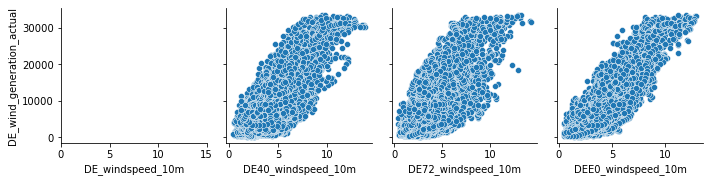

In [38]:
g = sns.pairplot(combined, x_vars=['DE_windspeed_10m','DE40_windspeed_10m','DE72_windspeed_10m', 'DEE0_windspeed_10m'], y_vars=['DE_wind_generation_actual'])
g.axes[0,0].set_xlim((0, 15))

There seems to be a linear relation between the wind generation and the wind velocity at 10m.
Looking at this in another way (to confirm the trend), the following additional Seaborne plot is made.

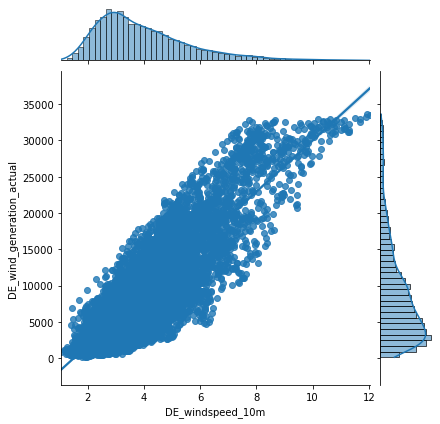

In [39]:
sns.jointplot(x='DE_windspeed_10m', y='DE_wind_generation_actual', data=combined, kind='reg')

Similarly, there seems to be a linear relation between wind generation and speed at 10m.

## 3. Linear regression algorithm

Given observations above, try a linear regression (supervided learning) algorithm to predict wind generation from some of the weather quantities.

In [40]:
# import necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Note firstly here, a brief definition / background on the sklearn linear regression predictve analysis tool.
#The linear regression model is essentially an ordinary least squares Linear Regression approach.
#LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares
#between the observed targets in the dataset, and targets predicted by the linear approximation.

# instantiate LinearRegression
lr = LinearRegression()

Note, the output of a linear regression algorithm is a linear function of the input

## 3.1. Wind generation

To predict wind generation, construct the features matrix `X_wind` with feature `DE_windspeed_10m` (and `DEE0_windspeed_10m` etc), and target `Y_wind` with `DE_wind_generation_actual`.

In [41]:
#This line of code checks firstly to see if there are any data missing in the 'combined' data set (False is yes, True is no).  
#combined.isnull().any()

In [42]:
#Hence from above result, it is certainly necessary to fill any NA/NaN values. The following line of code does that 
#combined = combined.fillna(method='ffill')

In [43]:
X_wind = combined[['DE_windspeed_10m', 'DE40_windspeed_10m', 'DE72_windspeed_10m', 'DEE0_windspeed_10m']]
y_wind = combined['DE_wind_generation_actual']
X_wind = X_wind.values.astype(np.float)
y_wind = y_wind.values.astype(np.float)

In [44]:
print(X_wind)

[[3.384917 2.85     3.1      4.26    ]
 [3.363631 3.07     3.04     4.05    ]
 [3.326812 3.02     3.1      4.      ]
 ...
 [4.287475 5.61     3.29     5.24    ]
 [4.29653  5.5      3.27     5.22    ]
 [4.419977 5.67     3.25     5.25    ]]


In [45]:
print(y_wind)

[ 8579.  8542.  8443. ... 15354. 14848. 15056.]


Now implementing a 5-fold CV procedure.

In [46]:
scores_wind = cross_val_score(lr, X_wind, y_wind, cv=10)
print(scores_wind, "\naverage =", np.mean(scores_wind))

[0.88555022 0.849099   0.73060058 0.5354672  0.08844001 0.6187522
 0.4464011  0.71964272 0.72609134 0.78666675] 
average = 0.6386711117783853


The first line contains ten values of $R^2$, one for each of the 10 folds in the cross validation procedure, and the second line is their average. Note that at around 8 to 10 folds, the average result converges to around 0.6.

The first point here is to highlight that some folds do actually provide a very good approxmation ($R^2$ > 0.8), whereas others (such as $R^2$ = 0.088) are way off, and it is not easy from my perspective / experience with this type of linear regression modelling to understand exactly why this outcome is ocurring. 

In any case, and secondly, it is clear that the linear regression model provides overall a fair approximation but it is a simple model! We can not make good predictions about the wind generation in Germany in 2016 given only the features of wind velocities in different regions as they are too random and vary too much (as seen in the comparions of the four diffenret locations in the plot above). Perhaps running some sensitvities on the various sklearn model packages may improve the cross validation exercise.  